<a href="https://colab.research.google.com/github/Pathin220/4105_Hw6/blob/main/HW6_P2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import time
from torchvision import datasets
from torchvision import transforms
import seaborn as sns

In [2]:
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

100%|██████████| 170498071/170498071 [00:13<00:00, 12979705.24it/s]


Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/
Files already downloaded and verified


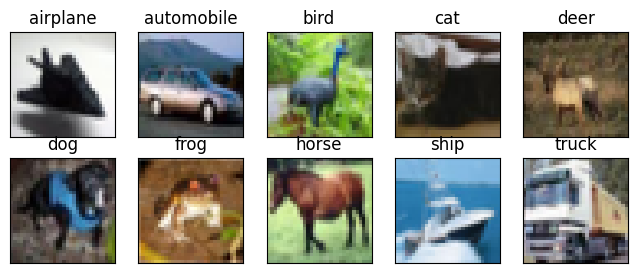

In [3]:
# Code from dlwpt repository
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

In [4]:
# Convert dataset to tensors
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
transform=transforms.ToTensor())

In [5]:
# Normalizing Data
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
print(imgs.view(3, -1).mean(dim=1))
print(imgs.view(3, -1).std(dim=1))

tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


In [6]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))]))
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))]))
transformed_cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data-unversioned/p1ch7/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))
           )

In [7]:
# Problem 2a.
# Create a fully connected Neural Network for all 10 classes in CIFAR-10 with only one hidden layer with a size of 512.
# Report your training time, training loss, and evaluation accuracy. Analyze your results in your report.
# Make sure to submit your code by providing the GitHub URL of your course repository for this course.

In [8]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [9]:
n_out = 10
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.ReLU(),
            nn.Linear(512, n_out),
            nn.LogSoftmax(dim=1)
        )

In [10]:
#created if, else to determine if you are running CPU or GPU
if torch.cuda.is_available():
    # Create a device object for the GPU
    device = torch.device('cuda')
else:
    # Create a device object for the CPU
    device = torch.device('cpu')
device

device(type='cuda')

In [11]:
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64, shuffle=True)

In [12]:
model = model.to(device)
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100
timer_s = time.time()

count_loss = []


In [13]:
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    count_loss.append(float(loss))
    if epoch %10 == 0 or epoch == 100:
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
timer_e = time.time()
train_time = timer_e - timer_s
print("Training Time:", train_time, "seconds")

Epoch: 0, Loss: 1.579634
Epoch: 10, Loss: 0.981458
Epoch: 20, Loss: 0.828877
Epoch: 30, Loss: 0.399298
Epoch: 40, Loss: 0.241821
Epoch: 50, Loss: 0.274119
Epoch: 60, Loss: 0.341020
Epoch: 70, Loss: 0.057071
Epoch: 80, Loss: 0.077989
Epoch: 90, Loss: 0.039596
Training Time: 1338.0960400104523 seconds


In [14]:
# Training Accuracy
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64, shuffle=False)
train_correct = 0
train_total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        train_total += labels.shape[0]
        train_correct += int((predicted == labels).sum())

print("Training Accuracy: %f" % (train_correct / train_total))

# Validation Accuracy
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64,shuffle=False)
val_correct = 0
val_total = 0

val_loss = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        val_total += labels.shape[0]
        val_correct += int((predicted == labels).sum())

print("Validation Accuracy: %f" % (val_correct / val_total))

Training Accuracy: 0.998820
Validation Accuracy: 0.529400


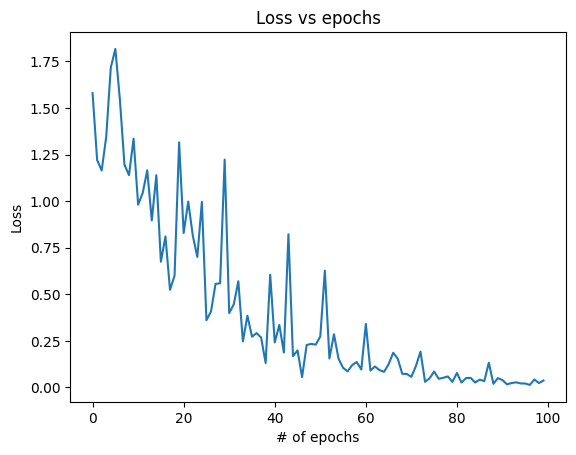

In [15]:
# Plot Loss over epochs
plt.figure(1)
plt.plot(range(n_epochs), count_loss)
plt.title("Loss vs epochs")
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.show()

In [16]:
#Problem 2b.
#Extend your network with two more additional hidden layers, like the example we did in the lecture (pick the sizes of hidden layers properly).
#Train your network. Report your training time, loss, and evaluation accuracy after 300 epochs.
#Analyze your results in your report and compare your model size and accuracy over the baseline implementation in Problem 2.a.
#Do you see any over-fitting? Can you compare your model complexity against problem 2.a?
#Make sure to submit your code by providing the GitHub URL of your course repository for this course.

In [17]:
model_2 = nn.Sequential(
     nn.Linear(3072, 1024),
     nn.ReLU(),
     nn.Linear(1024, 512),
     nn.ReLU(),
     nn.Linear(512, 128),
     nn.ReLU(),
     nn.Linear(128, 10))
model_2

Sequential(
  (0): Linear(in_features=3072, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=10, bias=True)
)

In [18]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))]))

In [19]:
train_loader_2 = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64, shuffle=True)

In [20]:
model_3 = model_2.to(device)
learning_rate_2 = 1e-3
optimizer_2 = optim.SGD(model_3.parameters(), lr=learning_rate_2)
loss_fn_2 = nn.CrossEntropyLoss()
n_epochs = 300

timer_s = time.time()
count_loss_2 = []

In [21]:
for epoch in range(n_epochs):
    for imgs, labels in train_loader_2:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model_3(imgs.view(imgs.shape[0], -1))
        loss = loss_fn_2(outputs, labels)

        optimizer_2.zero_grad()
        loss.backward()
        optimizer_2.step()

    count_loss_2.append(float(loss))
    if epoch %10 == 0 or epoch == 300:
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
timer_e = time.time()
train_time = timer_e - timer_s
print("Training Time:", train_time, "seconds")

Epoch: 0, Loss: 2.276150
Epoch: 10, Loss: 2.154319
Epoch: 20, Loss: 1.263863
Epoch: 30, Loss: 1.559136
Epoch: 40, Loss: 1.654022
Epoch: 50, Loss: 1.140451
Epoch: 60, Loss: 0.894778
Epoch: 70, Loss: 0.706830
Epoch: 80, Loss: 1.172639
Epoch: 90, Loss: 1.415419
Epoch: 100, Loss: 0.322968
Epoch: 110, Loss: 0.600736
Epoch: 120, Loss: 0.268548
Epoch: 130, Loss: 0.173990
Epoch: 140, Loss: 0.147732
Epoch: 150, Loss: 0.082849
Epoch: 160, Loss: 0.103435
Epoch: 170, Loss: 0.074092
Epoch: 180, Loss: 0.069700
Epoch: 190, Loss: 0.063378
Epoch: 200, Loss: 0.020892
Epoch: 210, Loss: 0.027480
Epoch: 220, Loss: 0.013163
Epoch: 230, Loss: 0.010967
Epoch: 240, Loss: 0.011783
Epoch: 250, Loss: 0.010638
Epoch: 260, Loss: 0.007866
Epoch: 270, Loss: 0.003594
Epoch: 280, Loss: 0.004604
Epoch: 290, Loss: 0.002896
Training Time: 4080.911276578903 seconds


In [22]:
# Training Accuracy
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64, shuffle=False)
train_correct = 0
train_total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_3(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        train_total += labels.shape[0]
        train_correct += int((predicted == labels).sum())

print("Training Accuracy: %f" % (train_correct / train_total))

# Validation Accuracy
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64, shuffle=False)
val_correct = 0
val_total = 0

val_loss_2 = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_3(imgs.view(imgs.shape[0], -1))
        loss = loss_fn_2(outputs, labels)
        _, predicted = torch.max(outputs, dim=1)
        val_total += labels.shape[0]
        val_correct += int((predicted == labels).sum())

print("Validation Accuracy: %f" % (val_correct / val_total))

Training Accuracy: 1.000000
Validation Accuracy: 0.525800


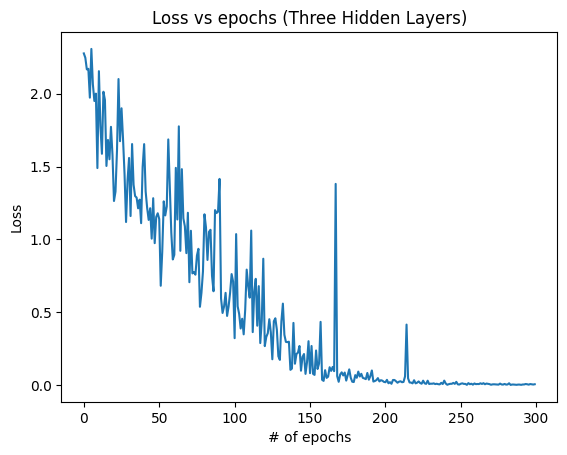

In [23]:
# Plot Loss over epochs
plt.figure(1)
plt.plot(range(n_epochs), count_loss_2)
plt.title("Loss vs epochs (Three Hidden Layers)")
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.show()